## Loading the packages

In [54]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets
import os

%matplotlib inline

In [55]:
PATH = '../vowels'

from python_speech_features import mfcc
import scipy.io.wavfile as wav

import glob
nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

# Imports Dataset

In [56]:
# Here we read the wave files and store their content in lists
naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]

In [57]:
nam_audios

[(24000, array([ -1, -26, -44, ..., -13, -12,  -6], dtype=int16)),
 (24000, array([ -1, -22, -38, ...,  -7,  -6,  -4], dtype=int16)),
 (24000, array([  0,  -4,  -7, ..., -47, -39, -20], dtype=int16)),
 (24000, array([ 0, -3,  0, ..., -1, -1,  0], dtype=int16)),
 (24000, array([  0,  -8, -20, ...,   6,   7,   4], dtype=int16)),
 (24000, array([ 0, -2, -1, ..., -9, -7, -3], dtype=int16)),
 (24000, array([  0,  10,  23, ...,  -7, -15, -12], dtype=int16)),
 (24000, array([  0, -10,  -8, ...,  -3,  -2,  -1], dtype=int16)),
 (24000, array([ 0,  1, 13, ...,  0,  4,  4], dtype=int16)),
 (24000, array([ -1, -18, -15, ..., -15, -13,  -6], dtype=int16)),
 (24000, array([ -1, -23, -47, ..., -23, -17,  -8], dtype=int16)),
 (24000, array([ 0,  6, 12, ..., -2, -1, -1], dtype=int16)),
 (24000, array([ 0,  6,  5, ..., -6, -5, -3], dtype=int16)),
 (24000, array([ -1, -13, -30, ..., -13, -11,  -6], dtype=int16)),
 (24000, array([0, 1, 4, ..., 2, 3, 2], dtype=int16)),
 (24000, array([ 1, 25, 51, ...,  4, 

# Analyse DATA

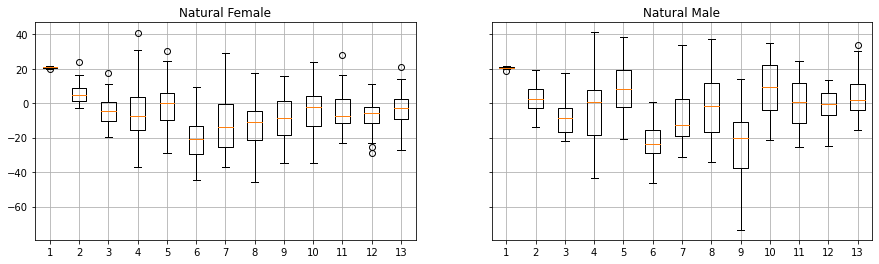

In [58]:
naf_mfcc_median = np.array([np.median(mfcc(naf[1], naf[0], nfft=1024), axis=0) for naf in naf_audios])# ...
nam_mfcc_median = np.array([np.median(mfcc(nam[1], nam[0], nfft=1024), axis=0) for nam in nam_audios])# ...


f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

On a trouvé que les paires de MFCC (8,9), (8,4), (9,4) pourraient être utiles pour la prédiction

In [59]:
from matplotlib import colors

mfcc_5  = np.concatenate((nam_mfcc_median[:,4], naf_mfcc_median[:,4]))

# Create an array of the true class of each points
# The classes number (0, 1) is expected to be in the
# same order as the MFCCs
classes = np.concatenate((
    np.repeat(0, len(nam_mfcc_median)), # Class 'natural male' is 0
    np.repeat(1, len(naf_mfcc_median))  # Class 'natural female' is 1
))

def scatter_mfcc(no1, no2) :
    mfcc_1  = np.concatenate((nam_mfcc_median[:,no1], naf_mfcc_median[:,no1]))
    mfcc_2  = np.concatenate((nam_mfcc_median[:,no2], naf_mfcc_median[:,no2]))

    color = ['blue', 'red']
    pl.scatter(mfcc_1, mfcc_2, c=classes, cmap=colors.ListedColormap(color))
    cb = pl.colorbar()
    loc = np.arange(0,max(classes),max(classes)/float(len(color)))
    cb.set_ticks(loc)
    cb.set_ticklabels(color)

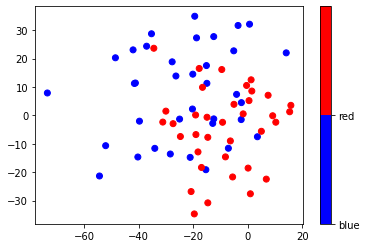

In [60]:
scatter_mfcc(8, 9)

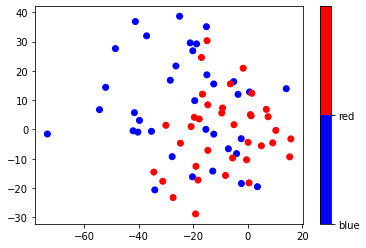

In [61]:
scatter_mfcc(8, 4)

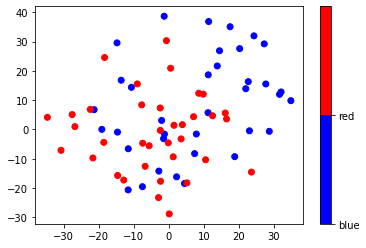

In [62]:
scatter_mfcc(9, 4)

# MLP

## Exploring the number of epochs and hyper parameters

In [90]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

mfccs = np.concatenate((
    nam_mfcc_median, #select the two columns of MFCC you're interested in, see point (2)
    naf_mfcc_median #select the two columns of MFCC you're interested in, see point (2)
))

mfccs_2 = np.concatenate((
    nam_mfcc_median[:, [4, 8]], #select the two columns of MFCC you're interested in, see point (2)
    naf_mfcc_median[:, [4, 8]] #select the two columns of MFCC you're interested in, see point (2)
))

mfccs_3 = np.concatenate((
    nam_mfcc_median[:, [8, 9]], #select the two columns of MFCC you're interested in, see point (2)
    naf_mfcc_median[:, [8, 9]] #select the two columns of MFCC you're interested in, see point (2)
))

classes = np.concatenate(
    (
        np.repeat(0, len(nam_mfcc_median)), # Class 'natural male' is 0
        np.repeat(1, len(naf_mfcc_median))  # Class 'natural female' is 1
    )
)

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [91]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()

        MSE[i_h, i, :] = nn.fit((mfccs, classes),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


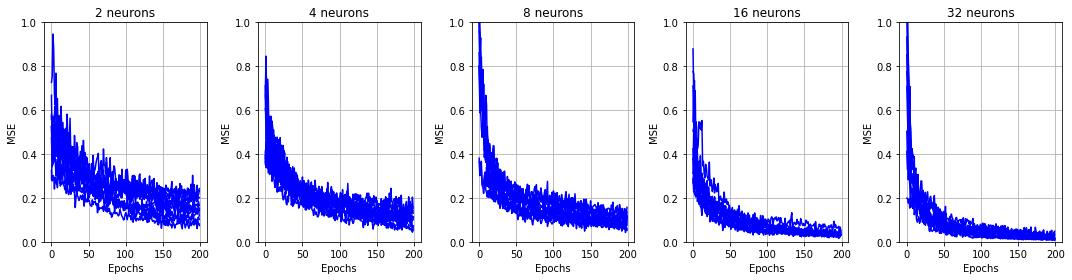

In [92]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

array([[-8.26853846e+00,  7.41084955e+00],
       [ 1.39090618e+01,  2.20279641e+01],
       [-1.84681652e+01,  4.50619406e+00],
       [ 2.16722724e+01,  1.38784527e+01],
       [ 1.63272606e+01,  2.27420806e+01],
       [-1.56587570e+00,  7.90212286e+00],
       [ 1.68044730e+01, -1.35825439e+01],
       [ 1.86445197e+01,  1.13035123e+01],
       [-2.06573552e+01, -1.15900248e+01],
       [-9.30059270e+00,  1.88688888e+01],
       [-9.22626129e-01, -1.46401783e+01],
       [ 1.43780607e+01, -1.06510900e+01],
       [-1.61910384e+01,  2.25600414e+00],
       [ 1.27988210e+01,  3.21153347e+01],
       [-1.42295062e+01, -2.80970492e+00],
       [ 2.92183039e+01,  2.73044674e+01],
       [ 9.82130838e+00,  3.49147014e+01],
       [-4.71431456e-01,  2.30793121e+01],
       [ 3.86574087e+01, -1.28772780e+00],
       [ 3.19634750e+01,  2.43674926e+01],
       [-1.60646208e+00, -1.21704159e+00],
       [-6.45694535e-01,  2.87472906e+01],
       [ 2.76044115e+01,  2.02896929e+01],
       [ 3.